In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
import json

kaggle_token = {
    "username": "dhiyafadhl",
    "key": "KEY"
}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_token, f)
!chmod 600 /root/.kaggle/kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c demand-forecasting-kernels-only -p /content/drive/MyDrive/KaggleData
!unzip -o /content/drive/MyDrive/KaggleData/*.zip -d /content/drive/MyDrive/KaggleData/


demand-forecasting-kernels-only.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/KaggleData/demand-forecasting-kernels-only.zip
  inflating: /content/drive/MyDrive/KaggleData/sample_submission.csv  
  inflating: /content/drive/MyDrive/KaggleData/test.csv  
  inflating: /content/drive/MyDrive/KaggleData/train.csv  


In [6]:
import pandas as pd

# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/KaggleData/train.csv')
test = pd.read_csv('/content/drive/MyDrive/KaggleData/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/KaggleData/sample_submission.csv')

# Show a sample of the training data
train.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [10]:
# Import necessary libraries and make necessary arrangements
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [11]:
# HELPER FUNCTIONS (UTILS)

# Check dataframe
def check_df(dataframe, head=5, tail=5, quan=False):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(tail))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    if quan:
        print("##################### Quantiles #####################")
        print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Date Features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

# Custom Cost Function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

# Kaggle input part
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [12]:
########################
# Loading the data
# ########################
# train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
# test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
# sample_sub = pd.read_csv('../input/demand-forecasting-kernels-only/sample_submission.csv')
df = pd.concat([train, test], sort=False)

#### **EXPLORATORY DATA ANALYSIS**

In [13]:
# Let's check the time periods of train and test sets
df["date"].min(), df["date"].max()

('2013-01-01', '2018-03-31')

In [14]:
train["date"].min(), train["date"].max()

('2013-01-01', '2017-12-31')

In [15]:
test["date"].min(), test["date"].max()

('2018-01-01', '2018-03-31')

In [16]:
check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     object
store     int64
item      int64
sales     int64
dtype: object
##################### Head #####################
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
##################### Tail #####################
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64


In [17]:
check_df(test)

##################### Shape #####################
(45000, 4)
##################### Types #####################
id        int64
date     object
store     int64
item      int64
dtype: object
##################### Head #####################
   id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1
##################### Tail #####################
          id        date  store  item
44995  44995  2018-03-27     10    50
44996  44996  2018-03-28     10    50
44997  44997  2018-03-29     10    50
44998  44998  2018-03-30     10    50
44999  44999  2018-03-31     10    50
##################### NA #####################
id       0
date     0
store    0
item     0
dtype: int64


In [18]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date      object
store      int64
item       int64
sales    float64
id       float64
dtype: object
##################### Head #####################
         date  store  item  sales  id
0  2013-01-01      1     1   13.0 NaN
1  2013-01-02      1     1   11.0 NaN
2  2013-01-03      1     1   14.0 NaN
3  2013-01-04      1     1   13.0 NaN
4  2013-01-05      1     1   10.0 NaN
##################### Tail #####################
             date  store  item  sales       id
44995  2018-03-27     10    50    NaN  44995.0
44996  2018-03-28     10    50    NaN  44996.0
44997  2018-03-29     10    50    NaN  44997.0
44998  2018-03-30     10    50    NaN  44998.0
44999  2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64


In [19]:
# Distribution of sales
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

,sales
count,913000.000000
mean,52.250287
std,28.801144
min,0.000000
10%,20.000000
30%,33.000000
50%,47.000000
70%,64.000000
80%,76.000000
90%,93.000000


In [20]:
# Number of stores
df[["store"]].nunique()

,0
store,10


In [21]:
# Number of items
df[["item"]].nunique()

,0
item,50


In [22]:
# Number of unique items for each store
df.groupby(["store"])["item"].nunique()

,item
store,
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


In [23]:
# Sales distribution per store and item
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [24]:
# Sales statistics per store and item
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

#### **FEATURE ENGINEERING**

In [25]:
########################
# Date Features
########################
df['date'] = pd.to_datetime(df['date'])
df = create_date_features(df)
check_df(df)

##################### Shape #####################
(958000, 14)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end
0 2013-01-01      1     1   13.0 NaN      1             1            1             1            1  2013        0               1             0
1 2013-01-02      1     1   11.0 NaN      1             2            2      

In [26]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [27]:
########################
# Lag/Shifted Features
########################
# Below sort_values() is so important!
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [28]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [29]:
check_df(df)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object
##################### Head #####################
        date  store  item  sales

In [30]:
########################
# Rolling Mean Features
########################
df = roll_mean_features(df, [365, 546])
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,40.499539,52.062085,66.591055,68.252189,69.544681,78.615739,79.082474,59.661135,95.673447,74.141845,89.556612,89.073514
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.273345,49.511986,66.838314,57.502122,77.111633,81.340670,78.649440,73.831761,79.732913,68.139258,89.399532,86.721879
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,59.810435,64.257901,74.136305,65.459382,72.317683,87.910064,82.327872,67.705079,99.669766,73.168152,86.860850,87.056242
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,72.296979,75.376142,71.331985,67.580727,66.597203,81.541204,88.988481,70.011881,80.339622,82.299815,86.564920,86.740725
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,1,0,1,63.375111,71.086366,54.402129,68.076758,49.204179,77.744954,104.447175,100.739443,97.572016,80.806870,87.307727,86.732273


In [31]:
########################
# Exponentially Weighted Mean Features
########################
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

check_df(df)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sale

In [32]:
########################
# One-Hot Encoding
########################
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

In [33]:
########################
# Converting sales to log(1+sales)
########################
df['sales'] = np.log1p(df["sales"].values)

#### **MODEL**

* MAE: mean absolute error
* MAPE: mean absolute percentage error
* SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [34]:
########################
# Time-Based Validation Sets
########################
# Train set till the beginning of 2017
train = df.loc[(df["date"] < "2017-01-01"), :]

# Validation set including first 3 months of 2017 (as we will forecast the first 3 months of 2018)
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [35]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [36]:
# Define dependent variable and independent variables
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [37]:
# Observe the shapes
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 142), (45000,), (45000, 142))

In [38]:
########################
# LightGBM Model
########################
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [39]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [40]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[lgb.early_stopping(lgb_params['early_stopping_rounds']), lgb.log_evaluation(100)],
                  feval=lgbm_smape)

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.172699	training's SMAPE: 17.6112	valid_1's l1: 0.170966	valid_1's SMAPE: 17.4745
[200]	training's l1: 0.14229	training's SMAPE: 14.5729	valid_1's l1: 0.145229	valid_1's SMAPE: 14.8981
[300]	training's l1: 0.136764	training's SMAPE: 14.0196	valid_1's l1: 0.140687	valid_1's SMAPE: 14.443
[400]	training's l1: 0.134584	training's SMAPE: 13.8026	valid_1's l1: 0.139165	valid_1's SMAPE: 14.2908
[500]	training's l1: 0.133233	training's SMAPE: 13.6679	valid_1's l1: 0.137935	valid_1's SMAPE: 14.1672
[600]	training's l1: 0.132268	training's SMAPE: 13.5715	valid_1's l1: 0.136847	valid_1's SMAPE: 14.0577
[700]	training's l1: 0.131548	training's SMAPE: 13.4996	valid_1's l1: 0.136036	valid_1's SMAPE: 13.9762
[800]	training's l1: 0.130983	training's SMAPE: 13.4429	valid_1's l1: 0.135408	valid_1's SMAPE: 13.9129
[900]	training's l1: 0.13048	training's SMAPE: 13.3926	valid_1's l1: 0.134996	valid_1's SMAPE: 13.8715
[1000

In [41]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [42]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

np.float64(13.834385733555875)

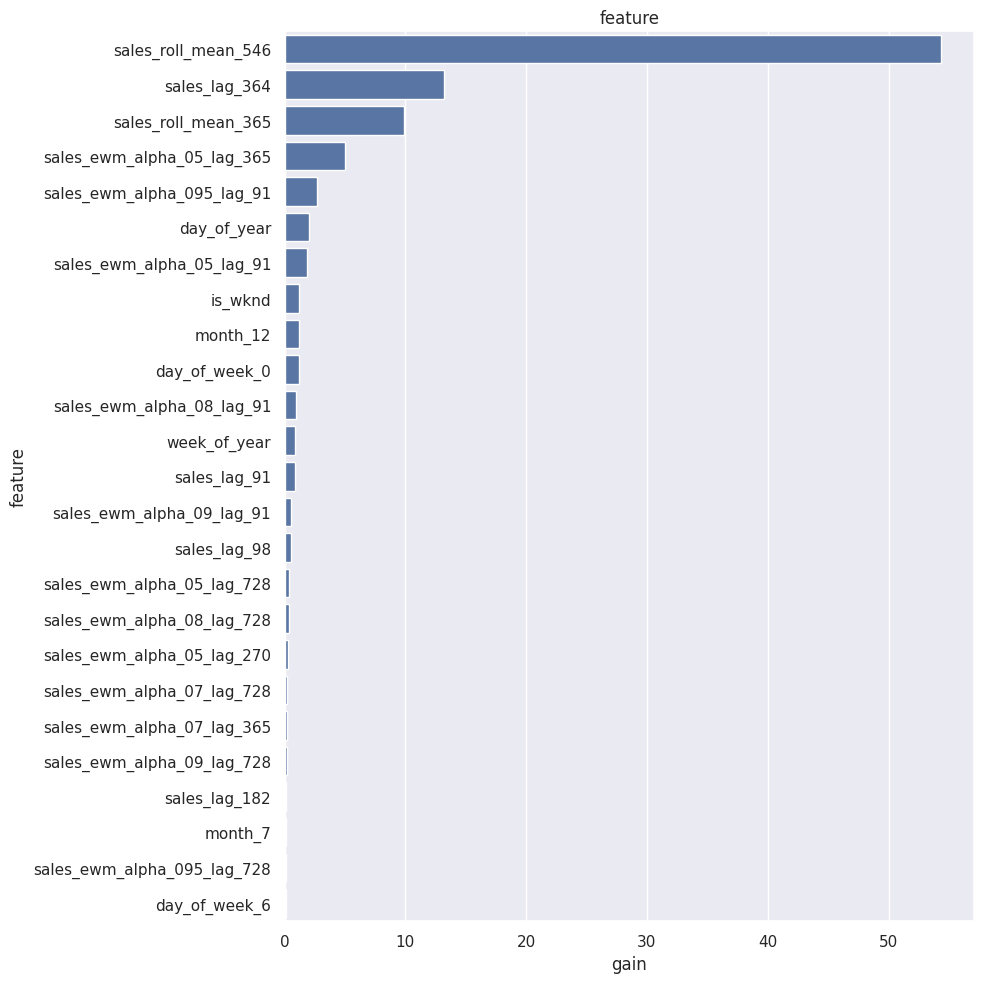

In [43]:
########################
# Feature importance
########################
plot_lgb_importances(model, num=30, plot=True)

In [44]:
########################
# Final Model
########################
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [45]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [46]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [47]:
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

In [48]:
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

In [49]:
########################
# Submission
########################
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission_demand.csv', index=False)
submission_df.head(20)

,id,sales
0,0,13.230934
1,1,14.665504
2,2,13.024491
3,3,14.114884
4,4,16.428553
5,5,18.169625
6,6,20.015855
7,7,12.891191
8,8,15.269767
9,9,14.614821


In [50]:
import pickle

# Save the model
with open('/content/drive/My Drive/lgbm_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the submission dataframe
submission_df.to_csv('/content/drive/My Drive/submission_demand.csv', index=False)

print("Model and submission file saved to Google Drive.")

Model and submission file saved to Google Drive.


In [52]:
import pickle
import pandas as pd

with open('/content/drive/MyDrive/lgbm_model.pkl', 'rb') as f:
    model = pickle.load(f)

print("✅ تم تحميل النموذج بنجاح")


✅ تم تحميل النموذج بنجاح


In [55]:
def prepare_input(store, item, date_str, feature_columns):
    import pandas as pd
    from datetime import datetime

    # تحويل التاريخ إلى خصائص
    date = pd.to_datetime(date_str)
    day_of_week = date.dayofweek
    month = date.month
    year = date.year
    day = date.day

    # إدخال خام
    input_df = pd.DataFrame({
        'store': [store],
        'item': [item],
        'day_of_week': [day_of_week],
        'month': [month],
        'year': [year],
        'day': [day]
    })

    # One-Hot Encoding مشابه لما تم في التدريب
    input_encoded = pd.get_dummies(input_df, columns=['store', 'item', 'day_of_week', 'month'])

    # ملء الأعمدة الناقصة بقيمة 0، وترتيب الأعمدة حسب `feature_columns` المستخدمة في التدريب
    for col in feature_columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0

    # إعادة ترتيب الأعمدة
    input_encoded = input_encoded[feature_columns]

    return input_encoded


In [ ]:

import pickle
with open('/content/drive/MyDrive/lgbm_model.pkl', 'rb') as f:
    model = pickle.load(f)


input_df = prepare_input(store=3, item=25, date_str='2018-05-01', feature_columns=cols)

# التوقع
prediction = model.predict(input_df)[0]
print(f"📈 المبيعات المتوقعة: {prediction:.2f}")


📈 المبيعات المتوقعة: 2.06


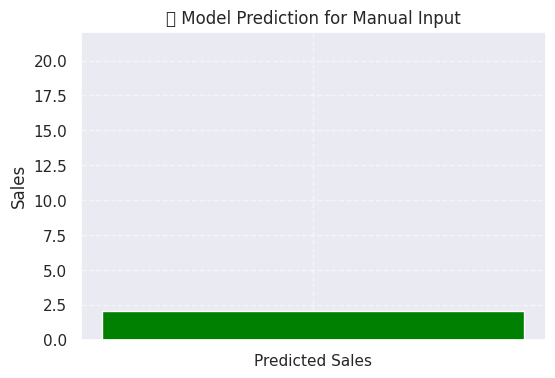

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(['Predicted Sales'], [prediction], color='green')
plt.title('📊 Model Prediction for Manual Input')
plt.ylabel('Sales')
plt.ylim(0, max(10, prediction + 20))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
